# **Google Play Apps Review - Sentiment Analysis**

#### **Import Libraies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import pickle
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('bmh')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ikiga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum() / input_data.isnull().count() * 100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

In [3]:
df = pd.read_csv('data/reviews.csv')

df.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo
5,gp:AOqpTOEvElPsBa6k8rLDmk-WrEoJea98KUrIGYWodJe...,Jon Clemens,https://play-lh.googleusercontent.com/-q6L1fx0...,It has changed how I viewed my different lists...,1,1,5.6.0.7,2020-10-26 05:04:20,Please note that in order to sort the lists by...,2020-10-26 14:56:25,newest,com.anydo
6,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,0,5.6.0.6,2020-10-25 23:40:46,Sorry about that. We are not aware of any issu...,2020-10-26 14:53:42,newest,com.anydo
7,gp:AOqpTOEcxvv_c0CK3G5tHjxXsGSjbzD65OQ3og02p-q...,No One,https://play-lh.googleusercontent.com/a-/AOh14...,"Reset my free trial, new phone I'd like to see...",1,0,5.5.0.8,2020-10-25 19:18:13,We have an extensive Help Center detailing how...,2020-10-26 14:43:36,newest,com.anydo
8,gp:AOqpTOHVgr7_qOhORsfPwnVCqX-n98dJ1Ksrps6q52p...,I Dewa Gede Nopi Ariana,https://play-lh.googleusercontent.com/a-/AOh14...,How do to stop monthly payment because i don't...,1,0,5.6.0.7,2020-10-25 10:09:00,Please note that you may cancel your subscript...,2020-10-26 14:39:59,newest,com.anydo
9,gp:AOqpTOHQ_paQ_ffWsMqGOWmMsPxs-pBkBgR_3H63WJv...,John Riddle,https://play-lh.googleusercontent.com/a-/AOh14...,I complain about not crashes and it was immedi...,1,1,5.6.0.7,2020-10-23 03:15:01,We are unaware of any issues with the app not ...,2020-10-25 17:11:06,newest,com.anydo


## **Data Profile**

In [4]:
df.shape

(12495, 12)

In [5]:
df.dtypes

reviewId                object
userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
sortOrder               object
appId                   object
dtype: object

In [6]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [7]:
#Column names

print(f"Feature names : {df.columns.values}")

Feature names : ['reviewId' 'userName' 'userImage' 'content' 'score' 'thumbsUpCount'
 'reviewCreatedVersion' 'at' 'replyContent' 'repliedAt' 'sortOrder'
 'appId']


In [8]:
df['nopunc'] = df['content'].apply(lambda x: [c for c in x if c not in string.punctuation])
df['nopunc'] = df['nopunc'].apply(''.join)

df.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,nopunc
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,I cannot open the app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,I have been begging for a refund from this app...
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,Very costly for the premium version approx Ind...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,Used to keep me organized but all the 2020 UPD...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,Dan Birthday Oct 28
5,gp:AOqpTOEvElPsBa6k8rLDmk-WrEoJea98KUrIGYWodJe...,Jon Clemens,https://play-lh.googleusercontent.com/-q6L1fx0...,It has changed how I viewed my different lists...,1,1,5.6.0.7,2020-10-26 05:04:20,Please note that in order to sort the lists by...,2020-10-26 14:56:25,newest,com.anydo,It has changed how I viewed my different lists...
6,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,Gale W,https://play-lh.googleusercontent.com/a-/AOh14...,I'm only looking for a grocery list app but ev...,1,0,5.6.0.6,2020-10-25 23:40:46,Sorry about that. We are not aware of any issu...,2020-10-26 14:53:42,newest,com.anydo,Im only looking for a grocery list app but eve...
7,gp:AOqpTOEcxvv_c0CK3G5tHjxXsGSjbzD65OQ3og02p-q...,No One,https://play-lh.googleusercontent.com/a-/AOh14...,"Reset my free trial, new phone I'd like to see...",1,0,5.5.0.8,2020-10-25 19:18:13,We have an extensive Help Center detailing how...,2020-10-26 14:43:36,newest,com.anydo,Reset my free trial new phone Id like to see i...
8,gp:AOqpTOHVgr7_qOhORsfPwnVCqX-n98dJ1Ksrps6q52p...,I Dewa Gede Nopi Ariana,https://play-lh.googleusercontent.com/a-/AOh14...,How do to stop monthly payment because i don't...,1,0,5.6.0.7,2020-10-25 10:09:00,Please note that you may cancel your subscript...,2020-10-26 14:39:59,newest,com.anydo,How do to stop monthly payment because i dont ...
9,gp:AOqpTOHQ_paQ_ffWsMqGOWmMsPxs-pBkBgR_3H63WJv...,John Riddle,https://play-lh.googleusercontent.com/a-/AOh14...,I complain about not crashes and it was immedi...,1,1,5.6.0.7,2020-10-23 03:15:01,We are unaware of any issues with the app not ...,2020-10-25 17:11:06,newest,com.anydo,I complain about not crashes and it was immedi...


## **Apply TQDM**

In [9]:
tqdm_res = {}
sia = SentimentIntensityAnalyzer()

for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['reviewId']
        tqdm_res[myid] = sia.polarity_scores(text)
    except Exception as e:
        print(f"Error processing row {index}: {e}")

  0%|          | 0/12495 [00:00<?, ?it/s]

In [10]:
vad = pd.DataFrame(tqdm_res).T
vad = vad.reset_index().rename(columns={'index': 'reviewId'})
vad.head(10)

,reviewId,neg,neu,pos,compound
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,0.00,1.00,0.00,0.00
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,0.00,1.00,0.00,0.00
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,0.04,0.81,0.15,0.66
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,0.20,0.77,0.03,-0.86
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,0.00,1.00,0.00,0.00
5,gp:AOqpTOEvElPsBa6k8rLDmk-WrEoJea98KUrIGYWodJe...,0.00,1.00,0.00,0.00
6,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,0.03,0.94,0.03,-0.00
7,gp:AOqpTOEcxvv_c0CK3G5tHjxXsGSjbzD65OQ3og02p-q...,0.00,0.54,0.47,0.83
8,gp:AOqpTOHVgr7_qOhORsfPwnVCqX-n98dJ1Ksrps6q52p...,0.17,0.83,0.00,-0.30
9,gp:AOqpTOHQ_paQ_ffWsMqGOWmMsPxs-pBkBgR_3H63WJv...,0.04,0.96,0.00,-0.44


In [11]:
vad.columns

Index(['reviewId', 'neg', 'neu', 'pos', 'compound'], dtype='object')

In [12]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'sortOrder', 'appId', 'nopunc'],
      dtype='object')

In [13]:
vad = vad.merge(df, how='left')
vad.columns

Index(['reviewId', 'neg', 'neu', 'pos', 'compound', 'userName', 'userImage',
       'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at',
       'replyContent', 'repliedAt', 'sortOrder', 'appId', 'nopunc'],
      dtype='object')

In [14]:
vad = vad.drop(['userName', 'userImage','thumbsUpCount', 'reviewCreatedVersion', 'at',
       'replyContent', 'repliedAt', 'sortOrder'],axis = 1)
vad.head(10)

,reviewId,neg,neu,pos,compound,content,score,appId,nopunc
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,0.00,1.00,0.00,0.00,I cannot open the app anymore,1,com.anydo,I cannot open the app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,0.00,1.00,0.00,0.00,I have been begging for a refund from this app...,1,com.anydo,I have been begging for a refund from this app...
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,0.04,0.81,0.15,0.66,Very costly for the premium version (approx In...,1,com.anydo,Very costly for the premium version approx Ind...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,0.20,0.77,0.03,-0.86,"Used to keep me organized, but all the 2020 UP...",1,com.anydo,Used to keep me organized but all the 2020 UPD...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,0.00,1.00,0.00,0.00,Dan Birthday Oct 28,1,com.anydo,Dan Birthday Oct 28
5,gp:AOqpTOEvElPsBa6k8rLDmk-WrEoJea98KUrIGYWodJe...,0.00,1.00,0.00,0.00,It has changed how I viewed my different lists...,1,com.anydo,It has changed how I viewed my different lists...
6,gp:AOqpTOGHb-APKKMNFyL1OwuGq1AGW6bQp5aYYxSHvJx...,0.03,0.94,0.03,-0.00,I'm only looking for a grocery list app but ev...,1,com.anydo,Im only looking for a grocery list app but eve...
7,gp:AOqpTOEcxvv_c0CK3G5tHjxXsGSjbzD65OQ3og02p-q...,0.00,0.54,0.47,0.83,"Reset my free trial, new phone I'd like to see...",1,com.anydo,Reset my free trial new phone Id like to see i...
8,gp:AOqpTOHVgr7_qOhORsfPwnVCqX-n98dJ1Ksrps6q52p...,0.17,0.83,0.00,-0.30,How do to stop monthly payment because i don't...,1,com.anydo,How do to stop monthly payment because i dont ...
9,gp:AOqpTOHQ_paQ_ffWsMqGOWmMsPxs-pBkBgR_3H63WJv...,0.04,0.96,0.00,-0.44,I complain about not crashes and it was immedi...,1,com.anydo,I complain about not crashes and it was immedi...


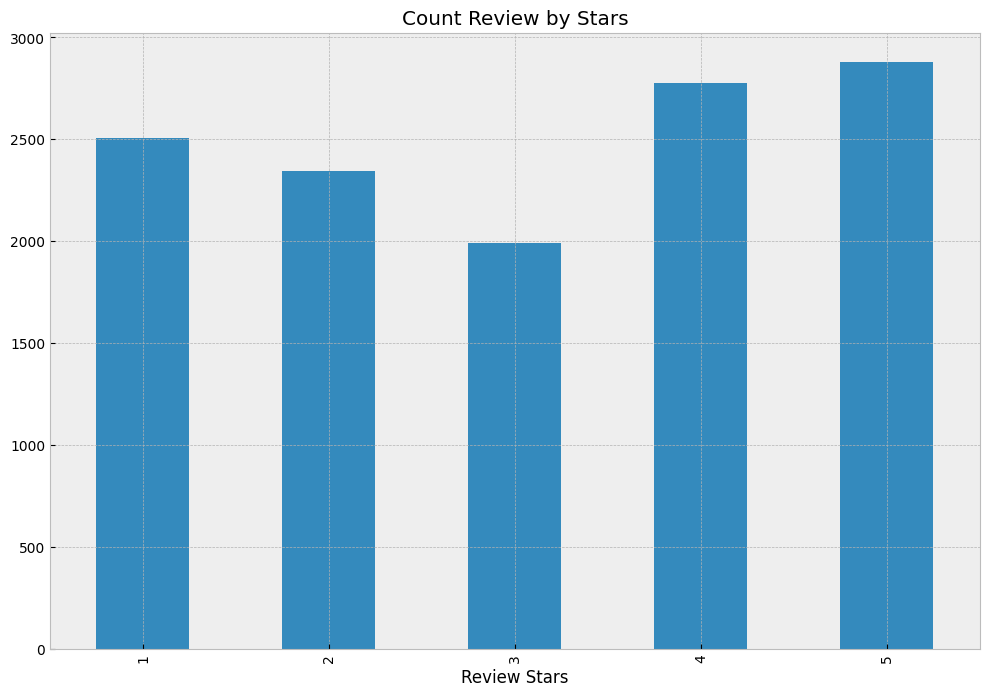

In [15]:
review_plot = df['score'].value_counts().sort_index().plot(kind='bar', title="Count Review by Stars", figsize=(12,8))
review_plot.set_xlabel('Review Stars')
plt.show()


In [16]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(df['score'].value_counts()/df.shape[0]*100,2)}")

Rating value count - percentage distribution: 
score
5   23.04
4   22.21
1   20.06
2   18.76
3   15.93
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of rating'>

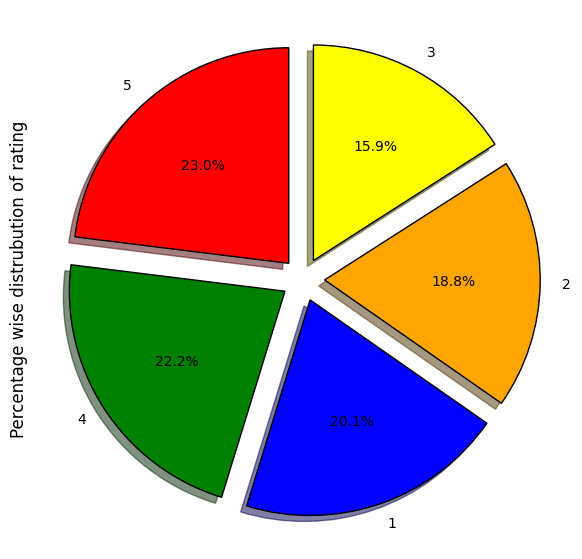

In [17]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue','orange','yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = df['score'].value_counts()/df.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

## **Plot Vader Results**

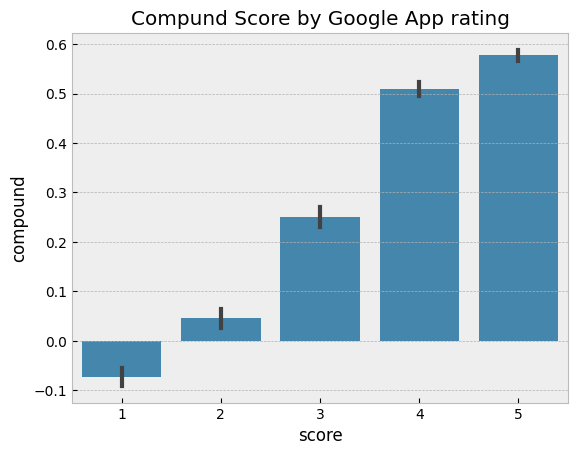

In [18]:
ax = sns.barplot(data=vad, x='score', y='compound')
ax.set_title('Compund Score by Google App rating')
plt.show()

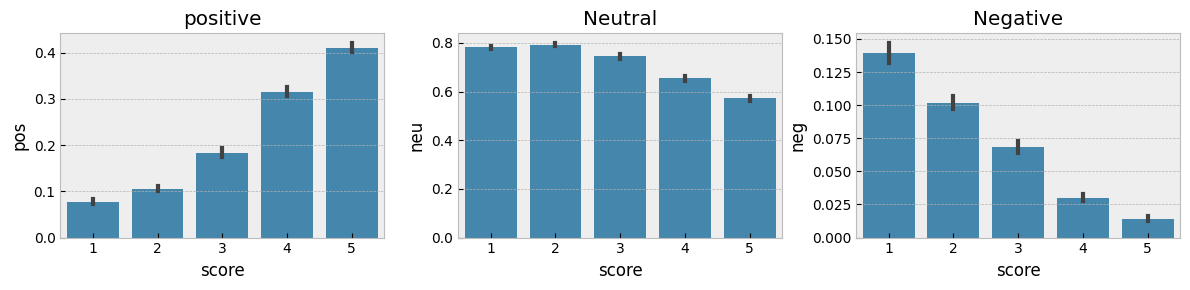

In [19]:
fig,axs = plt.subplots(1,3, figsize =(12,3))
sns.barplot(data = vad, x ='score',y ='pos', ax= axs[0])
sns.barplot(data = vad, x ='score',y ='neu', ax= axs[1])
sns.barplot(data = vad, x ='score',y ='neg', ax= axs[2])

axs[0].set_title('positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


## **Roberta Pretrained Model**

In [20]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
example = "It is not working"
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [22]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)


{'roberta_neg': 0.4748591, 'roberta_neu': 0.47272998, 'roberta_pos': 0.052410953}


In [23]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [24]:
res={}
for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['reviewId']
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
        vader_result_rename ={}
        for key,value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'reviewId'})
results_df = results_df.merge(vad, how='left')
results_df.head()

  0%|          | 0/12495 [00:00<?, ?it/s]

Broke for id gp:AOqpTOG-yLPXe4GxbSsDa2aUT2vBKCQYLGM-bSAfJDOepGOYjYURfPekdhXKentQfnzyo2PwtTOPVFZ3WtlrHa0
Broke for id gp:AOqpTOEsSp_4QOhxbTIu3fEpWxiOIYFE3t4XmkTqmRZMGHGQ1uV427CsmyH4Vy6vzu7cWARTkkdUooe1hZgTxg
Broke for id gp:AOqpTOEKDIPD9FWPqz5HvglBU1f1h82MiHfkPjkcQjdP0b7phBynBAU0BaYhP79cR_VcajqcDXkdob07WolVWQ
Broke for id gp:AOqpTOFW67J6jJDlFWahpUDDExopgYL5PTYfvCvqbit0wUIW-kmw_zm_-ILPPcBxupNc2o6KNzm0tDARANkl
Broke for id gp:AOqpTOH6_huL2kpzlzPl3DelNWIhiy3DAB8KYFgplZ9v0O5I6H7lrLHYWFxJDKiQ6oxxxLlTV7SFkXKLot53
Broke for id gp:AOqpTOE9t1H9W90Kzu-jCJ17yOCr6B_fzqQ7sbcSfTX2SS3E8UInHHc1PUdY1CJdCAC0Kujnts3vL7aP9WF1HXQ


,reviewId,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,content,score,appId,nopunc
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,0.00,1.00,0.00,0.00,0.74,0.24,0.02,0.00,1.00,0.00,0.00,I cannot open the app anymore,1,com.anydo,I cannot open the app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,0.00,1.00,0.00,0.00,0.90,0.08,0.01,0.00,1.00,0.00,0.00,I have been begging for a refund from this app...,1,com.anydo,I have been begging for a refund from this app...
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,0.04,0.81,0.15,0.66,0.30,0.50,0.20,0.04,0.81,0.15,0.66,Very costly for the premium version (approx In...,1,com.anydo,Very costly for the premium version approx Ind...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,0.20,0.77,0.03,-0.86,0.80,0.18,0.02,0.20,0.77,0.03,-0.86,"Used to keep me organized, but all the 2020 UP...",1,com.anydo,Used to keep me organized but all the 2020 UPD...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,0.00,1.00,0.00,0.00,0.01,0.71,0.28,0.00,1.00,0.00,0.00,Dan Birthday Oct 28,1,com.anydo,Dan Birthday Oct 28


In [25]:
results_df.columns

Index(['reviewId', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'neg', 'neu', 'pos',
       'compound', 'content', 'score', 'appId', 'nopunc'],
      dtype='object')

In [26]:
vad = vad.drop(['content'],axis = 1)
vad.head()

,reviewId,neg,neu,pos,compound,score,appId,nopunc
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,0.00,1.00,0.00,0.00,1,com.anydo,I cannot open the app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,0.00,1.00,0.00,0.00,1,com.anydo,I have been begging for a refund from this app...
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,0.04,0.81,0.15,0.66,1,com.anydo,Very costly for the premium version approx Ind...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,0.20,0.77,0.03,-0.86,1,com.anydo,Used to keep me organized but all the 2020 UPD...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,0.00,1.00,0.00,0.00,1,com.anydo,Dan Birthday Oct 28


In [28]:
results_df.drop(columns=['content'], inplace=True)
results_df.head()

,reviewId,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,score,appId,nopunc
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,0.00,1.00,0.00,0.00,0.74,0.24,0.02,0.00,1.00,0.00,0.00,1,com.anydo,I cannot open the app anymore
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,0.00,1.00,0.00,0.00,0.90,0.08,0.01,0.00,1.00,0.00,0.00,1,com.anydo,I have been begging for a refund from this app...
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,0.04,0.81,0.15,0.66,0.30,0.50,0.20,0.04,0.81,0.15,0.66,1,com.anydo,Very costly for the premium version approx Ind...
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,0.20,0.77,0.03,-0.86,0.80,0.18,0.02,0.20,0.77,0.03,-0.86,1,com.anydo,Used to keep me organized but all the 2020 UPD...
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,0.00,1.00,0.00,0.00,0.01,0.71,0.28,0.00,1.00,0.00,0.00,1,com.anydo,Dan Birthday Oct 28


## **Preprocessing and Modelling**

In [100]:
corpus = []
stemmer = PorterStemmer()

for i in range(0, results_df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', results_df.iloc[i]['nopunc'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [105]:
cv = CountVectorizer(max_features = 1000)

X = results_df['nopunc'].values
y = results_df['score'].values

In [106]:
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (8742,)
y train: (8742,)
X test: (3747,)
y test: (3747,)


In [108]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 🥰🥰🥰🥰
X test max value: 😍


In [109]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

ValueError: could not convert string to float: 'This app is amazing it has a very user friendly interface Id say its great for developing habits making short daily task list But the only downside is there is no calendar view So I cant plan ahead and time things for the long run Thats why Im giving it 3 stars'

In [96]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

## **Model**

In [97]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9362846030656601
Testing Accuracy : 0.4328796370429677


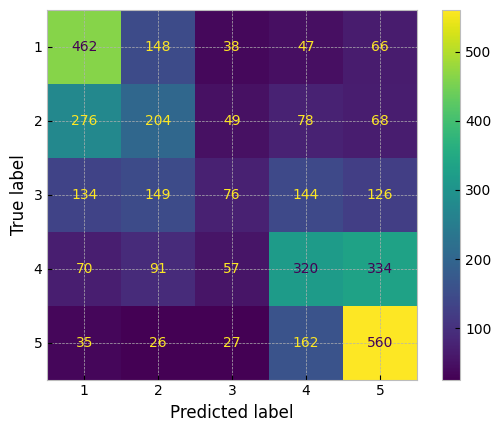

In [98]:
y_preds = model_rf.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [99]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 5)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.4318226956757245
Standard Variance : 0.01139436273580999
